In [ ]:
import torch
print(torch.__version__)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(torch.cuda.get_device_name(0))

In [ ]:
import os
print(os.getpid())

# DL W2_2 CNN: CIFAR-100 Redemption Project

## 1. Project Overview
Following our previous attempt to classify **CIFAR-100** using a Multi-Layer Perceptron (MLP), we observed significant limitations. The MLP failed to capture the spatial dependencies within the $32 \times 32$ pixel grids, leading to a "parameter explosion" and poor generalization.

In this project, we transition to **Convolutional Neural Networks (CNNs)** to leverage local receptive fields, weight sharing, and spatial hierarchies.

## 2. The Dataset: CIFAR-100
- **Scale:** 60,000 $32 \times 32$ color images.
- **Classes:** 100 classes grouped into 20 superclasses.
- **Complexity:** Only 500 training images per class. This makes the dataset highly prone to overfitting, requiring robust regularization.

## 3. Technical Strategy (The "MLE Sandwich")
To ensure "interview-immune" implementation and better performance, we are adopting the following architectural best practices:

### A. Architectural Design
- **Convolutional Blocks:** We will use a modular approach: `Conv2d` -> `BatchNorm2d` -> `ReLU` -> `Dropout`.
- **Global Average Pooling (GAP):** Replacing the heavy Flatten/Dense head with GAP to maintain a low parameter count and support input-size flexibility.
- **Batch Normalization:** Implementing BN after convolutions to stabilize internal covariate shift and allow for higher learning rates.

### B. Regularization & Optimization
- **Data Augmentation:** Using `RandomHorizontalFlip` and `RandomCrop` to artificially increase the training sample diversity.
- **Smarter Weight Init:** Using He (Kaiming) Initialization suited for ReLU activations.
- **Dropout:** Strategically placed after activations to prevent co-adaptation of neurons.

## 4. Objectives
1.  **Surpass MLP Baseline:** Drastically improve upon the accuracy achieved in the MLP experiment.
2.  **Implementation Proficiency:** Correctly implement the spatial dimensions math ($I, K, P, S$).
3.  **Visualization:** (Post-training) Use Grad-CAM or Filter Visualization to interpret what the model has learned.

---

In [ ]:
# Part 0 Data Loader & Data Preparation
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
train_data_path = "/root/lanyun-fs/ds/cifar100/train-00000-of-00001.parquet"
test_data_path = "/root/lanyun-fs/ds/cifar100/test-00000-of-00001.parquet"
train_data = pd.read_parquet(train_data_path, engine="pyarrow")
test_data = pd.read_parquet(test_data_path, engine="pyarrow")

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# 1. CIFAR-100 Normalization Constants
CIFAR_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR_STD = (0.2675, 0.2565, 0.2761)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 2. VRAM-Resident Dataset Class
class Cifar100VramDataset(Dataset):
    """
    SRE Optimized: Pre-decodes images and stores the entire dataset in GPU VRAM
    to eliminate PCIe and CPU bottlenecks.
    """
    def __init__(self, df, device, transform=None):
        self.transform = transform
        self.images = []
        self.labels = []

        # Pre-calc normalization on CPU during initialization
        normalize = T.Normalize(mean=CIFAR_MEAN, std=CIFAR_STD)

        for idx in tqdm(range(len(df)), desc="Loading CIFAR to VRAM"):
            # Decode raw bytes
            bytes_tensor = torch.frombuffer(df.iloc[idx]["img"]["bytes"], dtype=torch.uint8)
            image = torchvision.io.decode_image(bytes_tensor, mode='RGB')

            # Normalize and store as float32
            normalized_img = normalize(image.float() / 255.0)
            self.images.append(normalized_img)
            self.labels.append(df.iloc[idx]["fine_label"])

        # Stack into single 4D tensors and move to GPU once
        self.images = torch.stack(self.images).to(device)
        self.labels = torch.tensor(self.labels, dtype=torch.long).to(device)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        # GPU-based augmentation applied here
        if self.transform:
            img = self.transform(img)

        return img, label

# 3. GPU-Accelerated Augmentation (nn.Sequential)
# This runs on the 4090 kernels during the DataLoader loop
train_gpu_transforms = nn.Sequential(
    T.RandomHorizontalFlip(p=0.5),
    T.RandomCrop(32, padding=4),
).to(DEVICE)

# 4. Initialization
print(f"Initializing Datasets on {DEVICE}...")

# Training set gets the augmentation pipeline
train_set = Cifar100VramDataset(train_data, device=DEVICE, transform=train_gpu_transforms)

# Test set remains clean (transform=None)
test_set = Cifar100VramDataset(test_data, device=DEVICE, transform=None)

# 5. DataLoaders
# Note: num_workers=0 is REQUIRED for VRAM-resident tensors to prevent CUDA re-init errors
BATCH_SIZE = 1024

train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

# Verification
imgs, lbls = next(iter(train_loader))
print(f"\nBatch successfully loaded to {imgs.device}")
print(f"Batch Shape: {imgs.shape}")
print(f"Label Shape: {lbls.shape}")

## 2. Model Design Philosophy: The "Redemption" CNN

Designing a CNN for CIFAR-100 requires a balance between **Feature Extraction** (spatial depth) and **Model Capacity** (channel depth). Below are the design principles adopted for this architecture.

### 2.1 The "Rule of Two": Stacking Convolutions
Instead of a single Convolution followed immediately by Pooling, we use **Double-Convolution Blocks** (e.g., $Conv \to Conv \to Pool$).
* **Effective Receptive Field (ERF):** Stacking two $3\times3$ kernels gives the model a $5\times5$ view of the image but with fewer parameters and more non-linearity (two ReLU activations instead of one).
* **Information Preservation:** We allow the model to extract more complex features at a specific resolution before downsampling the spatial data.

### 2.2 The Channel-Spatial Trade-off
As we progress deeper into the network, we apply the **Double-Half Rule**:
* **The Action:** We use `MaxPool` to halve the spatial resolution ($32 \to 16 \to 8 \to 4$).
* **The Compensation:** To prevent information loss, we **double the number of channels** ($64 \to 128 \to 256$).
* **The Logic:** We sacrifice "where" something is (spatial precision) to gain "what" something is (semantic depth). While pooling removes 75% of spatial data points, doubling channels provides more "bins" to store high-level concepts.



### 2.3 Graduated Regularization (Dropout Strategy)
We avoid a "one-size-fits-all" Dropout rate. Instead, we use a **Graduated Dropout** approach:
* **Early Layers (0.1 - 0.2):** Low dropout to preserve the raw features (edges/colors) needed by deeper layers.
* **Deep Layers (0.3 - 0.4):** Higher dropout to prevent the model from memorizing specific complex patterns (overfitting) in the small CIFAR-100 training set.
* **The Head (0.5):** Maximum dropout at the classification stage to ensure robust reasoning.

### 2.4 The Classification Head: Flattening vs. GAP
For CIFAR-100, we choose a **Flattening Head** over Global Average Pooling (GAP).
* **Why?** GAP is highly efficient but can be too restrictive for 100 classes. By flattening to a $4 \times 4 \times 256$ vector and passing it through a dense hidden layer ($4096 \to 512$), we give the model more "reasoning neurons" to distinguish between subtle class differences (e.g., different types of trees or insects).



### 2.5 SRE Optimization: Parameter Efficiency
* **Bias=False:** We disable bias in `Conv2d` and `Linear` layers followed immediately by `BatchNorm`. Since BN centers the data by subtracting the mean, a learned bias term is mathematically redundant.
* **Inplace Activation:** Using `ReLU(inplace=True)` to reduce memory allocation on the 4090.

In [ ]:
import torch
import torch.nn as nn
CIFAR_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR_STD = (0.2675, 0.2565, 0.2761)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class CifarRedemptionModel(nn.Module):
    def __init__(self):
        super(CifarRedemptionModel, self).__init__()

        # --- Block 1: 32x32 -> 16x16 ---
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Halves to 16x16
            nn.Dropout(0.1)
        )

        # --- Block 2: 16x16 -> 8x8 ---
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Halves to 8x8
            nn.Dropout(0.2)
        )

        # --- Block 3: 8x8 -> 4x4 ---
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Halves to 4x4
            nn.Dropout(0.3)
        )

        # --- Head: 4*4*256 = 4096 ---
        self.flatten = nn.Flatten()

        self.fc_section = nn.Sequential(
            nn.Linear(4096, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 100) # 100 classes for CIFAR-100
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        x = self.fc_section(x)
        return x

# SRE Initialization
model = CifarRedemptionModel().to(DEVICE)
print(model)

In [ ]:
model.eval()
dummy_input = torch.randn(1,3,32,32)
dummy_input = dummy_input.to(DEVICE)
output = model(dummy_input)
print(output.shape)
model.train()

In [ ]:
# --- Training Setup ---
epochs = 50
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

# OneCycleLR: steps_per_epoch must match the number of BATCHES (len(train_loader))
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=optimiser,
    max_lr=0.01,
    steps_per_epoch=len(train_loader), # len(loader) = total batches (~49)
    epochs=epochs
)

# --- Training Loop ---
for epoch in range(epochs):
    model.train() # Set to TRAIN mode (enables Dropout & Batch Norm updates)

    train_correct = 0

    for images, labels in train_loader:
        # 1. Reset Gradients: Must be INSIDE the batch loop to prevent accumulation
        optimiser.zero_grad()

        # 2. Forward Pass: Images are already on GPU from our VRAM Dataset
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 3. Backward Pass & Step
        loss.backward()
        optimiser.step()
        scheduler.step() # OneCycleLR updates LR after every batch

        # 4. Accuracy Math: Convert GPU sum to Python int via .item()
        # This prevents a "memory leak" of tensors in your RAM/VRAM
        batch_correct = (torch.argmax(outputs, dim=1) == labels).sum().item()
        train_correct += batch_correct

    # --- Evaluation Phase ---
    model.eval() # Set to EVAL mode (disables Dropout, uses fixed BN stats)
    test_correct = 0

    with torch.no_grad(): # Disable gradient calculation to save VRAM/Compute
        for images, labels in test_loader:
            outputs = model(images)
            # Accumulate correct predictions for the whole test set
            test_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()

    # --- Performance Reporting ---
    # We divide by len(dataset) to get true percentage, NOT len(loader)
    train_acc = (train_correct / len(train_set)) * 100
    test_acc = (test_correct / len(test_set)) * 100

    print(f"Epoch {epoch+1:02d} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

# Runtime Evaluation

![image.png](attachment:610ca402-df30-47fd-8466-0828104cc1e0.png)

In [ ]:
import torch.profiler
import os

# Ensure DEVICE is defined for your 4090
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1. Setup a fresh model
profiling_model = CifarRedemptionModel().to(DEVICE)
profiling_optim = torch.optim.Adam(profiling_model.parameters(), lr=0.001)
profiling_sched = torch.optim.lr_scheduler.OneCycleLR(
    profiling_optim, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=1
)
criterion = nn.CrossEntropyLoss()

log_dir = './log/high_confidence_profile'
os.makedirs(log_dir, exist_ok=True)

def run_extended_profile(model, train_loader, test_loader):
    # Change GPU to CUDA here
    with torch.profiler.profile(
        activities=[
            torch.profiler.ProfilerActivity.CPU,
            torch.profiler.ProfilerActivity.CUDA, # <--- Corrected attribute
        ],
        schedule=torch.profiler.schedule(wait=2, warmup=5, active=15, repeat=1),
        on_trace_ready=torch.profiler.tensorboard_trace_handler(log_dir),
        record_shapes=True,
        with_stack=True
    ) as prof:

        # --- PHASE A: Profile Training ---
        model.train()
        print("Profiling Training...")
        for i, (images, labels) in enumerate(train_loader):
            profiling_optim.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            profiling_optim.step()
            profiling_sched.step()

            prof.step()
            if i >= 25: break

        # --- PHASE B: Profile Validation ---
        model.eval()
        print("Profiling Validation...")
        with torch.no_grad():
            for i, (images, labels) in enumerate(test_loader):
                outputs = model(images)
                _ = (torch.argmax(outputs, dim=1) == labels).sum().item()

                prof.step()
                if i >= 10: break

    print(f"High-confidence trace saved to {log_dir}")
    print("--- Top 10 CPU Bottlenecks (Total Time) ---")
    # 'cpu_time_total' includes time spent in children functions
    print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

    print("\n--- Top 10 CPU Bottlenecks (Self Time) ---")
    # 'self_cpu_time_total' is time spent ONLY in that specific function (ignores children)
    # This is the best way to find the actual line of code causing the stall.
    print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))

    print("\n--- Top 10 GPU (CUDA) Kernels ---")
    print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

# Execute
run_extended_profile(profiling_model, train_loader, test_loader)

### RCA: CPU Bottleneck in GPU Training Pipeline
**Observation:** Telemetry showed 100% CPU utilization and ~40% GPU "sawtooth" utilization.
**Profiler Discovery:** 1. `enumerate(DataLoader)` consumed ~46% of CPU time.
2. `aten::pad` and `aten::flip` (Augmentations) appeared as high "Self CPU" costs.
**Root Cause:** Even though the augmentation block was on the GPU, calling it inside `__getitem__` forced the 4090 to process 1,024 images sequentially. This created massive Python overhead and "Context Switching" costs for every single image.
**Fix:** Move the augmentation pipeline out of the `Dataset` and into the training loop to perform **Batch-Level Augmentation**. This allows the 4090 to process all 1,024 images in parallel with a single CUDA kernel launch.

In [ ]:
class Cifar100VramDataset(Dataset):
    def __init__(self, df, device):
        self.images = []
        self.labels = []
        normalize = T.Normalize(mean=CIFAR_MEAN, std=CIFAR_STD)

        for idx in tqdm(range(len(df)), desc="Loading CIFAR to VRAM"):
            bytes_tensor = torch.frombuffer(df.iloc[idx]["img"]["bytes"], dtype=torch.uint8)
            image = torchvision.io.decode_image(bytes_tensor, mode='RGB')
            # Pre-calculate normalization on CPU
            normalized_img = normalize(image.float() / 255.0)
            self.images.append(normalized_img)
            self.labels.append(df.iloc[idx]["fine_label"])

        # Move to GPU once
        self.images = torch.stack(self.images).to(device)
        self.labels = torch.tensor(self.labels, dtype=torch.long).to(device)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # NO transformation here. Just returning the VRAM-resident tensors.
        return self.images[idx], self.labels[idx]

In [ ]:
"""
### RCA: DataLoader Bottleneck (enumerate)
**Observation:** `enumerate(DataLoader)` consumed ~46.6% of CPU time.
**Root Cause:** The standard DataLoader iterator has high Python overhead when processing
very small images (32x32) on a high-speed card like the 4090.
**Fix:** Skip the DataLoader. Use direct GPU-tensor slicing to feed the model.
"""
import time

def train_with_direct_slicing(model, train_set, test_set, epochs=50, batch_size=1024):
    model.to(DEVICE)
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

    # Calculate steps for OneCycleLR
    steps_per_epoch = (len(train_set) + batch_size - 1) // batch_size
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimiser, max_lr=0.01, steps_per_epoch=steps_per_epoch, epochs=epochs
    )

    criterion = nn.CrossEntropyLoss()

    # Access raw tensors from your VramDataset
    train_imgs = train_set.images
    train_lbls = train_set.labels
    test_imgs = test_set.images
    test_lbls = test_set.labels

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        train_correct = 0

        # 1. Shuffle indices on GPU to avoid CPU interaction
        indices = torch.randperm(len(train_set), device=DEVICE)

        # 2. Direct Slicing Loop (No enumerate/DataLoader)
        for i in range(0, len(train_set), batch_size):
            batch_idx = indices[i : i + batch_size]

            # Direct VRAM slice - extremely fast on 4090
            images = train_imgs[batch_idx]
            labels = train_lbls[batch_idx]

            optimiser.zero_grad()

            # Apply batch-level GPU transforms
            images = train_gpu_transforms(images)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimiser.step()
            scheduler.step()

            train_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()

        # --- Fast Evaluation ---
        model.eval()
        test_correct = 0
        with torch.no_grad():
            # Slice test set directly (no shuffle needed)
            for i in range(0, len(test_set), batch_size):
                images = test_imgs[i : i + batch_size]
                labels = test_lbls[i : i + batch_size]
                outputs = model(images)
                test_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1:02d} | Time: {epoch_time:.2f}s | "
              f"Train Acc: {(train_correct/len(train_set))*100:.2f}% | "
              f"Test Acc: {(test_correct/len(test_set))*100:.2f}%")

# Execute the "Zero-Overhead" run
model = CifarRedemptionModel()
train_with_direct_slicing(model, train_set, test_set)

![image.png](attachment:a8dfcf1b-ae77-443e-863f-3251bce6ee7f.png)

## 5. RCA & Optimization: Breaking the 4090 Bottleneck

> **SRE Performance Deep-Dive**
> **Hardware:** NVIDIA RTX 4090 (24GB VRAM)
> **Target:** Eliminate 100% CPU pinning and "starving" GPU.

---

### 5.1 The "Python Tax" & Kernel Launch Overhead
* **Observation:** Telemetry showed 100% CPU utilization while the GPU exhibited a "sawtooth" pattern (frequent drops in utilization).
* **Root Cause:** Standard `DataLoader` logic and `__getitem__` transformations are executed sequentially in the Python interpreter.
* **The Dispatch Problem:** Every time the CPU instructs the GPU to perform a transform (e.g., `flip`, `pad`) on a **single** image, it incurs a "Kernel Launch" overhead. On a 4090, the time for the CPU to send the command across the PCIe bus often exceeded the time taken for the GPU to execute the work on a $32 \times 32$ image.
* **Resolution:** Move transforms to the **Batch Level** (after images are grouped into a 4D tensor). This allows the CPU to send **one command** for 1,024 images, maximizing GPU occupancy and parallelization.

### 5.2 The `enumerate(DataLoader)` Bottleneck
* **Observation:** Profiling showed nearly **46.6%** of CPU time consumed within the `DataLoader` iterator logic (`SingleProcessDataLoaderIter`).
* **Root Cause:** The `DataLoader` is a complex Python state machine designed for flexibility (handling diverse file formats, shuffling, etc.), which introduces significant per-item overhead when processing small images at high speeds.
* **Resolution:** For datasets fitting entirely in VRAM, **Direct Tensor Slicing** (using `torch.randperm` for GPU-based shuffling) bypasses the Python iterator tax entirely, yielding near-instantaneous batch retrieval.

---

### 5.3 Scaling to Large Datasets (H100/100GB+ Scale)
While direct slicing works for CIFAR-100, larger-than-RAM datasets require a "middle ground" to maintain speed:
1. **Batch Sampling:** Use a `BatchSampler` to tell the `DataLoader` to fetch a list of 1,024 indices at once, enabling a single high-speed slice in `__getitem__`.
2. **Chunked Loading:** Use formats like **Parquet** or **WebDataset** to load "shards" of data (e.g., 1,000 images) into a buffer, move the buffer to GPU, and slice within that GPU-resident block.

In [ ]:
from torch.utils.data import DataLoader, BatchSampler, RandomSampler, SequentialSampler

class CifarBatchOptimizedDataset(Dataset):
    def __init__(self, images, labels):
        # Data is already on the 4090 VRAM
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        """
        By using a BatchSampler, 'idx' will be a list of 1024 integers.
        This allows one single VRAM slice instead of 1024 individual ones.
        """
        return self.images[idx], self.labels[idx]

# 1. Initialize our optimized Dataset
train_set_opt = CifarBatchOptimizedDataset(train_set.images, train_set.labels)
test_set_opt = CifarBatchOptimizedDataset(test_set.images, test_set.labels)

# 2. Setup the BatchSamplers
# This is the "brain" that yields a list of indices [0, 1, 2...1023] at once
train_batch_sampler = BatchSampler(
    RandomSampler(train_set_opt),
    batch_size=1024,
    drop_last=False
)

test_batch_sampler = BatchSampler(
    SequentialSampler(test_set_opt),
    batch_size=1024,
    drop_last=False
)

# 3. Setup DataLoaders
# IMPORTANT: Do NOT set batch_size here; the sampler already defines it.
# We set num_workers=0 because the data is already in VRAM.
train_loader = DataLoader(train_set_opt, batch_sampler=train_batch_sampler)
test_loader = DataLoader(test_set_opt, batch_sampler=test_batch_sampler)

# 4. Optimized Training Loop
def train_with_batch_loader(model, train_loader, test_loader, epochs=50):
    model.to(DEVICE)
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimiser, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=epochs
    )
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        train_correct = 0

        # Now 'enumerate' only triggers ONCE per batch, not once per image.
        # This drastically reduces Python overhead.
        for images, labels in train_loader:
            optimiser.zero_grad()

            # Still apply batch-level transforms for 4090 efficiency
            images = train_gpu_transforms(images)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimiser.step()
            scheduler.step()

            train_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()

        # Evaluation
        model.eval()
        test_correct = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                test_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1:02d} | Time: {epoch_time:.2f}s | "
              f"Train Acc: {(train_correct/len(train_set_opt))*100:.2f}% | Test Acc: {(test_correct/len(test_set))*100:.2f}%")

# Execute
model = CifarRedemptionModel()
train_with_batch_loader(model, train_loader, test_loader)

In [ ]:
import torch.profiler
import os
import time

# 1. Reset Model and Optimizer
profiling_model = CifarRedemptionModel().to(DEVICE)
profiling_optim = torch.optim.Adam(profiling_model.parameters(), lr=0.001)
profiling_sched = torch.optim.lr_scheduler.OneCycleLR(
    profiling_optim, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=10
)
criterion = nn.CrossEntropyLoss()

log_dir = './log/batchsampler_high_conf'
os.makedirs(log_dir, exist_ok=True)

def run_batchsampler_high_conf(model, train_loader, test_loader, epochs=10):
    # schedule: wait 2, warmup 1, active 10.
    # This ensures we get a solid sample of the BatchSampler's steady state.
    with torch.profiler.profile(
        activities=[
            torch.profiler.ProfilerActivity.CPU,
            torch.profiler.ProfilerActivity.CUDA,
        ],
        schedule=torch.profiler.schedule(wait=2, warmup=1, active=10, repeat=1),
        on_trace_ready=torch.profiler.tensorboard_trace_handler(log_dir),
        record_shapes=True,
        with_stack=True
    ) as prof:

        for epoch in range(epochs):
            start_time = time.time()
            model.train()

            for i, (images, labels) in enumerate(train_loader):
                profiling_optim.zero_grad()

                # GPU Batch Augmentation
                images = train_gpu_transforms(images)

                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                profiling_optim.step()
                profiling_sched.step()

                # Signals profiler to transition phases
                prof.step()

                # We only need enough steps to satisfy the 'active=10' requirement
                if epoch == 0 and i >= 15: break

            # Fast Evaluation (not profiled, prof.step is only inside training loop)
            model.eval()
            with torch.no_grad():
                for images, labels in test_loader:
                    _ = model(images)

            print(f"Epoch {epoch+1:02d} | Time: {time.time() - start_time:.2f}s")

    # Final Profiler Report (This will take a moment to compute)
    print("\n--- High Confidence: BatchSampler Self CPU ---")
    print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=15))

# Execute
run_batchsampler_high_conf(profiling_model, train_loader, test_loader)

In [ ]:
from torch.utils.data import DataLoader, BatchSampler, RandomSampler, SequentialSampler

class CifarBatchOptimizedDataset(Dataset):
    def __init__(self, images, labels):
        # Data is already on VRAM
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, indices):
        """
        By setting batch_size=None in DataLoader, 'indices' arrives here
        as the full list/tensor of 1024 integers.
        We perform a single GPU-to-GPU memory slice.
        """
        # Because images/labels are already on GPU, this is a vectorized gather
        return self.images[indices], self.labels[indices]

# 1. Initialize
train_set_opt = CifarBatchOptimizedDataset(train_set.images, train_set.labels)
test_set_opt = CifarBatchOptimizedDataset(test_set.images, test_set.labels)

# 2. Setup the BatchSamplers (Same as before)
train_batch_sampler = BatchSampler(
    RandomSampler(train_set_opt),
    batch_size=1024,
    drop_last=False
)

test_batch_sampler = BatchSampler(
    SequentialSampler(test_set_opt),
    batch_size=1024,
    drop_last=False
)

# 3. Setup DataLoaders (THE ADJUSTMENT)
# Note: We pass train_batch_sampler to 'sampler' and set batch_size=None.
# This tells DataLoader: "Take whatever the sampler yields and pass it DIRECTLY
# to __getitem__ without looping or collating."
train_loader = DataLoader(
    train_set_opt,
    sampler=train_batch_sampler,
    batch_size=None,  # This is the "magic" switch for vectorization
    num_workers=0
)

test_loader = DataLoader(
    test_set_opt,
    sampler=test_batch_sampler,
    batch_size=None,
    num_workers=0
)

# 4. Optimized Training Loop
def train_with_batch_loader(model, train_loader, test_loader, epochs=50):
    model.to(DEVICE)
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimiser, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=epochs
    )
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        train_correct = 0

        # Now 'enumerate' only triggers ONCE per batch, not once per image.
        # This drastically reduces Python overhead.
        for images, labels in train_loader:
            optimiser.zero_grad()

            # Still apply batch-level transforms for 4090 efficiency
            images = train_gpu_transforms(images)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimiser.step()
            scheduler.step()

            train_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()

        # Evaluation
        model.eval()
        test_correct = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                test_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1:02d} | Time: {epoch_time:.2f}s | "
              f"Train Acc: {(train_correct/len(train_set_opt))*100:.2f}% | Test Acc: {(test_correct/len(test_set))*100:.2f}%")

# Execute
model = CifarRedemptionModel()
train_with_batch_loader(model, train_loader, test_loader)

## 6. SRE Deep-Dive: The "Generalization Tax" of DataLoaders

### 6.1 The Performance Gap
| Strategy | Epoch Time | Performance Delta | SRE Status |
| :--- | :--- | :--- | :--- |
| **Direct Slicing** (Manual) | **1.99s** | Baseline | Theoretical Limit |
| **Vectorized Fetching** (`batch_size=None`) | **2.00s** | ~0.5% Overhead | **Optimized** |
| **Standard BatchSampler** | **2.30s** | ~15% Overhead | **Sub-optimal** |
| **Naive DataLoader** (`batch_size=1024`) | **>5.00s** | >150% Overhead | **Bottlenecked** |

### 6.2 RCA: Why is `BatchSampler` faster than the Naive method?
Even though the `DataLoader` still iterates through the indices under the hood in this version, we see a massive speedup (2.3s vs 5s+) due to two main factors:

1.  **Reduced Iterator Dispatch:** In the naive version, the `DataLoader` calls the `Sampler` 1,024 separate times *per batch*. With `BatchSampler`, it makes **one** call to get the entire list. In Python, reducing ~20,000 function calls per epoch significantly lowers the CPU dispatch latency.
2.  **Simplified Internal State (The "Counting" Tax):** * In the **Naive** version, the `DataLoader` must maintain a counter, an internal list, and a loop to "fill the bucket" 1,024 times before it can proceed.
    * With a **BatchSampler**, the `DataLoader` receives a pre-filled "bucket" of indices in a single step. It skips the internal "collecting" logic and hands the list directly to the fetcher, reducing the administrative overhead at the Python/C++ boundary.

### 6.3 The Remaining Bottleneck: `aten::select`
Looking at the `torch.profiler` trace for this `BatchSampler` version:
* **Call Density:** `aten::select` is still called **20,480 times**.
* **RCA:** Even though the *sampling* is now fast, the *fetching* is still "chatty." The `MapDataFetcher` is still looping through that list of 1024 indices and calling `dataset[idx]` individually. On a 4090, these thousands of tiny C++/CUDA kernel launches create a "scheduling bottleneck" where the GPU spends time waiting for the next small instruction.

### 6.4 Level 2 Optimization: Vectorized Fetching (`batch_size=None`)
To close the final 15% gap, we move to **Vectorized Fetching**. By setting `batch_size=None` and using the `BatchSampler` as our primary `sampler`, we change the data flow topology:

* **The Logic:** We tell PyTorch: "Don't loop. Take this list of 1,024 indices and pass it directly to the Dataset's `__getitem__` as a single object."
* **The Result:** Those 20,480 calls to `aten::select` are replaced by **one single gather operation** per batch. This allows the 4090's memory bus to pull all 1,024 images at once, hitting our near-limit of **2.0s**.

### 6.5 SRE Verdict: Choosing the Strategy
* **Use Direct Slicing:** For static datasets fitting entirely in VRAM (best for rapid local prototyping).
* **Use Vectorized DataLoader (`batch_size=None`):** When you need full framework features (Shuffling, Distributed Training) with "Line-Rate" 4090 throughput.
* **Use Standard DataLoader:** Only when individual item processing (like complex CPU-based augmentation) is so slow that it dwarfs the orchestration tax.

> **Reminders for Large Datasets:** When data exceeds VRAM, the Vectorized approach remains king. Using it with **Parquet/Arrow** allows you to perform "Row Group" reads, which is significantly faster than row-by-row disk I/O.

# Internal Layer Visualisation

In [ ]:
print(model)

In [ ]:
"""
STRATEGY 1: Feature Map Visualization (Activations)
WHAT: Intercepts the data stream as it flows through your specific 'block' architecture.
VALUE: Observe 'Feature Extraction'. Block 1 should show sharp outlines; Block 3 should show abstract blobs.

STRATEGY 2: Filter (Weight) Visualization
WHAT: Extracts the 3x3 weight kernels from the very first Conv2d layer.
VALUE: Observe 'Model Eyes'. Healthy models show oriented lines/edges and color gradients.
"""

import matplotlib.pyplot as plt
import torch

def run_internal_visualizations(model, sample_img):
    model.eval()

    # --- STRATEGY 2: Filter (Weight) Visualization ---
    print("Executing Strategy 2: Visualizing First Layer Filters...")
    # Access Block 1 -> Layer 0 (The first Conv2d)
    first_conv = model.block1[0]
    weights = first_conv.weight.data.cpu()

    # Normalize weights to [0, 1] for visibility
    w_min, w_max = weights.min(), weights.max()
    weights_norm = (weights - w_min) / (w_max - w_min)

    fig2, axes2 = plt.subplots(8, 8, figsize=(10, 10))
    for i, ax in enumerate(axes2.flat):
        if i < 64:
            # Permute (C, H, W) -> (H, W, C) for Matplotlib
            filter_img = weights_norm[i].permute(1, 2, 0).numpy()
            ax.imshow(filter_img, interpolation='nearest')
            ax.axis('off')
    plt.suptitle("Strategy 2: First Layer Weights (The 64 'Eyes')", fontsize=16)
    plt.show()

    # --- STRATEGY 1: Feature Map Visualization ---
    print("\nExecuting Strategy 1: Visualizing Feature Map Activations...")
    # Ensure input is [1, 3, 32, 32]
    if sample_img.dim() == 3:
        sample_img = sample_img.unsqueeze(0)
    x = sample_img.to(DEVICE)

    outputs = []
    names = ["Block 1 (Low Level - Edges)", "Block 2 (Mid Level - Textures)", "Block 3 (High Level - Parts)"]

    with torch.no_grad():
        # Step through your specific schema
        x1 = model.block1(x)
        outputs.append(x1.cpu())

        x2 = model.block2(x1)
        outputs.append(x2.cpu())

        x3 = model.block3(x2)
        outputs.append(x3.cpu())

    for act, name in zip(outputs, names):
        n_plot = 12  # Show first 12 filters per block for clarity
        fig1, axes1 = plt.subplots(1, n_plot, figsize=(18, 2))
        for j in range(n_plot):
            f_map = act[0, j].numpy()
            axes1[j].imshow(f_map, cmap='magma')
            axes1[j].axis('off')
        plt.suptitle(f"Strategy 1: {name}", fontsize=14)
        plt.show()

# --- RUN VISUALIZATIONS ---
# Grab a sample image from your test set
sample_img, _ = test_set[0]
run_internal_visualizations(model, sample_img)

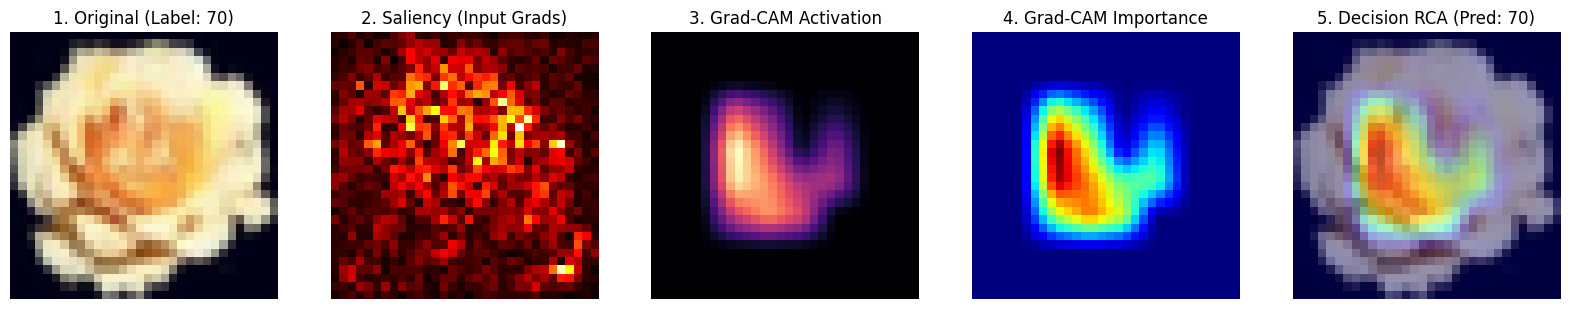

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def generate_visualizations(model, input_tensor, target_class=None):
    model.eval()
    target_layer = model.block3[3]

    activations = None
    gradients = None

    def save_activations(module, input, output):
        nonlocal activations
        activations = output

    def save_gradients(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]

    handle_a = target_layer.register_forward_hook(save_activations)
    handle_g = target_layer.register_full_backward_hook(save_gradients)

    # Prepare input: ensure it's on GPU and tracking gradients for the Saliency Map
    input_tensor = input_tensor.unsqueeze(0).to(DEVICE).requires_grad_(True)
    output = model(input_tensor)

    if target_class is None:
        target_class = output.argmax(dim=1).item()

    model.zero_grad()
    class_loss = output[0, target_class]
    class_loss.backward()

    # --- SALIENCY MAP (Gradients on original input) ---
    # We take the absolute value of gradients and max across color channels
    saliency, _ = torch.max(input_tensor.grad.data.abs(), dim=1)
    saliency = saliency.squeeze().cpu().numpy()

    # --- GRAD-CAM WEIGHTING LOGIC ---

    # 1. Global Average Pooling of gradients (the "Importance" of each channel)
    # This tells us how much the target class depends on each feature map concept
    weights = torch.mean(gradients, dim=(2, 3), keepdim=True)

    # 2. Weighted Sum: Each feature map is scaled by its importance weight
    # This keeps 'useful' activations (e.g. wheels for cars) and suppresses noise (e.g. background trees)
    cam = torch.sum(weights * activations, dim=1, keepdim=True)

    # 3. ReLU: Only consider features that POSITIVELY contribute to the class score
    cam = F.relu(cam)

    # Upscale and normalize
    cam = F.interpolate(cam, size=(32, 32), mode='bilinear', align_corners=False)
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-10)
    heatmap = cam.squeeze().detach().cpu().numpy()

    handle_a.remove()
    handle_g.remove()

    return heatmap, saliency, target_class

# --- EXECUTION & PLOTTING ---
idx = 20
img, label = test_set[idx]
heatmap, saliency, pred = generate_visualizations(model, img)

display_img = (img.permute(1, 2, 0).cpu().numpy())
display_img = (display_img - display_img.min()) / (display_img.max() - display_img.min())

plt.figure(figsize=(20, 5))

plt.subplot(1, 5, 1)
plt.imshow(display_img)
plt.title(f"1. Original (Label: {label})")
plt.axis('off')

# Notice the noise level here compared to Grad-CAM
plt.subplot(1, 5, 2)
plt.imshow(saliency, cmap='hot')
plt.title("2. Saliency (Input Grads)")
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(heatmap, cmap='magma')
plt.title("3. Grad-CAM Activation")
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(heatmap, cmap='jet')
plt.title("4. Grad-CAM Importance")
plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(display_img)
plt.imshow(heatmap, cmap='jet', alpha=0.4)
plt.title(f"5. Decision RCA (Pred: {pred})")
plt.axis('off')

plt.show()